#### Check Carlos' transfer function simulations at NERSC

In [1]:
import numpy as np
import pymaster as nmt
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
globals = {
    "Nsims": 10,
    "nside": 512,
    "cosmo": {
        "cosmomc_theta": 0.0104085,
        "As": 2.1e-9,
        "ombh2": 0.02237,
        "omch2": 0.1200,
        "ns": 0.9649,
        "Alens": 1.0,
        "tau": 0.0544,
        "r": 0.00,
    },
    "power_law": {
        "amp": 1.0,
        "delta_ell": 10,
        "power_law_index": 2.,
    },
    "bin_edges": [2, 29, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
                  150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
                  270, 280, 290, 300],
    "mask": "/global/homes/k/kwolz/bbdev/SOOPERCOOL/outputs_toast/masks/analysis_mask.fits",
    "sims": {
        "tf": "/global/cfs/projectdirs/sobs/awg_bb/sims/master-pipeline/[id_sim]/PLsim_20240323_nside512_[id_sim]_pureB_pwf_beam.fits",
        "tf_filtered": "/global/cfs/projectdirs/sobs/awg_bb/bbmaster_paper/TF_for_paper/pureB_pwf_beam/[id_sim]/filterbin_coadd-full_map.fits",
    }
}

In [3]:
def get_theory_cl(nside, params):
    """
    Specs: TT, EE, BB, TE (anafast compatible)
    """
    import camb
    params = camb.set_params(**params)
    results = camb.get_results(params)
    powers = results.get_cmb_power_spectra(params, CMB_unit='muK', raw_cl=True)
    return np.array(powers["total"][:, :4][:3*nside]).T.astype(np.float32)


def beam_gaussian(ll, fwhm_amin):
    """
    Returns the SHT of a Gaussian beam.
    Args:
        l (float or array): multipoles.
        fwhm_amin (float): full-widht half-max in arcmins.
    Returns:
        float or array: beam sampled at `l`.
    """
    sigma_rad = np.radians(fwhm_amin / 2.355 / 60)
    return np.exp(-0.5 * ll * (ll + 1) * sigma_rad**2).astype(np.float32)


def beam_hpix(ll, nside):
    """
    Returns the SHT of the beam associated with a HEALPix
    pixel size.
    Args:
        l (float or array): multipoles.
        nside (int): HEALPix resolution parameter.
    Returns:
        float or array: beam sampled at `l`.
    """
    fwhm_hp_amin = 60 * 41.7 / nside
    return beam_gaussian(ll, fwhm_hp_amin)


def get_power_law_cl(nside, params, nside_pixwin=None, smooth_arcmin=None):
    """
    """
    pl_ps = np.zeros((4, 3*nside))
    if nside_pixwin is not None:
        pixwin = beam_hpix(np.arange(3*nside), nside_pixwin)**2.
    else:
        pixwin = 1.
    if smooth_arcmin is not None:
        beam = beam_gaussian(np.arange(3*nside), smooth_arcmin)**2.
    else:
        beam = 1.
    for i, spec in enumerate(["TT", "EE", "BB", "TE"]):
        if isinstance(params["amp"], dict):
            A = params["amp"][spec]
        else:
            A = params["amp"]
        # A is power spectrum amplitude at pivot ell == 1 - delta_ell
        pl_ps[i] = A / (np.arange(3*nside) + params["delta_ell"]) ** params["power_law_index"]  # noqa

    return pl_ps * pixwin * beam


def load_sim(sims_dir, id_sim, nside):
    """
    """
    fname = sims_dir.replace("[id_sim]", str(id_sim).zfill(4))
    return hp.ud_grade(hp.read_map(fname, field=range(3)), nside_out=nside)


def get_nmt_bin(bin_edges, nside):
    """
    """
    bin_edges = np.array(bin_edges)
    bin_edges = bin_edges[bin_edges < 3*nside]
    bin_edges = np.concatenate((bin_edges, [3*nside]))
    return nmt.NmtBin.from_edges(bin_edges[:-1], bin_edges[1:])


def compute_workspace(nmt_bin, mask):
    """
    """
    f = nmt.NmtField(mask, None, spin=2, n_iter=0)
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(f, f, nmt_bin)
    return wsp


def compute_cl(mask, map, wsp):
    """
    """
    f = nmt.NmtField(mask, [map[1], map[2]])
    pcl = nmt.compute_coupled_cell(f, f)
    cl = wsp.decouple_cell(pcl)
    return cl


def bin_theory(cl, wsp):
    """
    """
    assert np.array(cl).ndim == 2
    return wsp.decouple_cell(wsp.couple_cell(cl))

In [4]:
Nsims = globals["Nsims"]
cosmo = globals["cosmo"]
power_law = globals["power_law"]
nside = globals["nside"]
bin_edges = globals["bin_edges"]

theory_cl = get_theory_cl(nside, cosmo)
power_law_cl = get_power_law_cl(nside, power_law, 512, 30.)
nmt_bin = get_nmt_bin(bin_edges, nside)
lb = nmt_bin.get_effective_ells()
mask = hp.ud_grade(hp.read_map(globals["mask"]), nside_out=nside)
wsp = compute_workspace(nmt_bin, mask)
theory_clb = bin_theory(theory_cl, wsp)
power_law_clb = bin_theory(power_law_cl, wsp)
clb = []
clb_filt = []

In [5]:
for id_sim in range(Nsims):
    print(id_sim)
    map = load_sim(globals["sims"]["tf"], id_sim, nside)
    map_filtered = load_sim(globals["sims"]["tf_filtered"], id_sim, nside)
    clb.append(compute_cl(mask, map, wsp))
    clb_filt.append(compute_cl(mask, map_filtered, wsp))

clb_mean, clb_std = (np.mean(np.array(clb), axis=0),
                   np.std(np.array(clb), axis=0))
clb_filt_mean, clb_filt_std = (np.mean(np.array(clb_filt), axis=0),
                             np.std(np.array(clb_filt), axis=0))

0
1
2
3
4
5
6
7
8
9


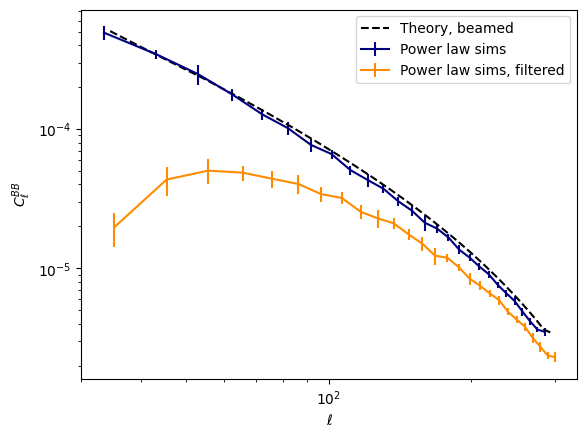

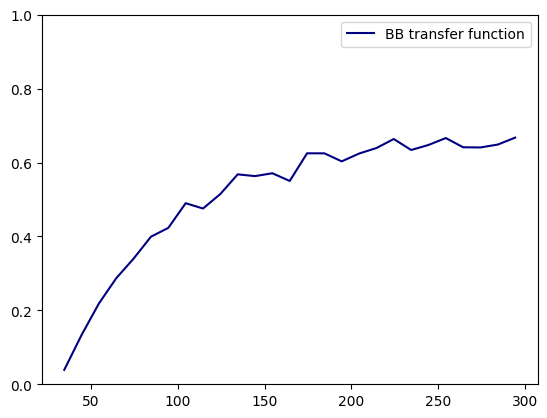

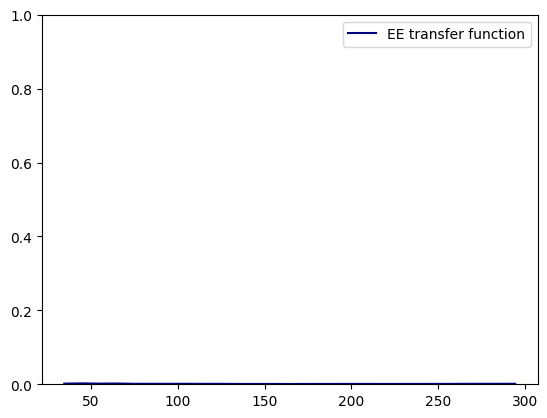

In [6]:
msk = np.logical_and(lb >= 30, lb <= 300)
x = lb[msk]
y = clb_mean[3][msk]
yerr = clb_std[3][msk]
yf = clb_filt_mean[3][msk]
yferr = clb_filt_std[3][msk]
yth = power_law_clb[2][msk]

plt.errorbar(x*0.97, y, yerr,
             color="navy", label="Power law sims")
plt.errorbar(x*1.02, yf, yferr,
             color="darkorange", label="Power law sims, filtered")
plt.plot(x, yth, "k--", label="Theory, beamed")
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$C_\ell^{BB}$")
plt.xlabel(r"$\ell$")
plt.legend()
plt.show()
plt.clf()

plt.plot(x, clb_filt_mean[3][msk] / yth, color="navy", label="BB transfer function")
plt.legend()
plt.ylim((0, 1))
plt.show()

plt.plot(x, clb_filt_mean[0][msk] / yth, color="navy", label="EE transfer function")
plt.legend()
plt.ylim((0, 1))
plt.show()

In [7]:
from astropy.io import fits
import healpy as hp
theory_fname = "/global/cfs/cdirs/sobs/users/krach/BBSims/CMB_r0_20201207/reference_spectra/Cls_Planck2018_r0.fits"
cl_cmb = hp.read_cl(theory_fname)

In [8]:
print(cl_cmb.shape)

(4, 4001)
